## Думаю, что для тестового задания лучше overexplain, буду пояснять что думал и что делал.
## Надеюсь вы будете запускать это в новом venv с установленным jupyterlab.  
#### Ставим нужные пакеты.

In [1]:
# Install all we need here
import sys

!{sys.executable} -m pip install -q pandas seaborn wordcloud nltk scikit-learn fasttext pymorphy2 tensorflow_text plotly==5.7.0 pyyaml==5.4.1 datasets transformers

In [2]:
import re
import os
from collections import Counter
from typing import List

import fasttext
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import psutil
import pymorphy2
from nltk.corpus import stopwords
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    roc_auc_score,                            
    roc_curve
)
from wordcloud import (
    WordCloud
)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tinctura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Проверим есть ли данные и если их нет, качаем

In [3]:
FILE_PATH = 'task/dataset/train.tsv'


if not os.path.isfile(FILE_PATH):
    !wget https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download
    !unzip "download" -d "task/"

#### Посмтрим на данные

In [4]:
data = pd.read_csv("task/dataset/train.tsv", sep="\t")

In [5]:
data.head()

title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1

In [6]:
data.shape

(5758, 2)

In [7]:
data["is_fake"].value_counts(normalize=True)

1    0.5
0    0.5
Name: is_fake, dtype: float64

In [8]:
data.isnull().sum()

title      0
is_fake    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


## Подготовим текст для дальнейшей работы. 
### Приведём к нижнему регистру, удалим знаки препинания и другие символы, выбросим стоп-слова, приведём все слова к нормальной форме (лемматизируем)

In [10]:
stop_words = stopwords.words("russian")
stop_words.append("изза")

morph = pymorphy2.MorphAnalyzer()


def remove_punctuations(text: str) -> str:
    """Remove punctuation from given text"""
    return re.sub('\[[^]]*\]', '', text)


def remove_characters(text: str) -> str:
    """Remove characters from given text"""
    return re.sub('[^а-яА-Я]', ' ', text)


def remove_stopwords(text: str) -> str:
    """Remove stop words from given text"""
    result = []
    for token in text.split():
        if token not in stop_words:
            result.append(token)
    return " ".join(result)


def normalize_text(text: str) -> str:
    """Normalize each word in given text"""
    normalized = []
    for element in text.split():
        normalized.append(morph.parse(element)[0].normal_form)
    return " ".join(normalized)


def clear_text(text: str) -> str:
    """Cleans given text"""
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords(text)
    text = normalize_text(text)
    return text


data["title_normalized"] = data["title"].apply(clear_text)
data.head(2)

title  is_fake  \
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1   
1  Агент Кокорина назвал езду по встречке житейск...        0   

                                    title_normalized  
0  москвич владимир клутина приша литр сч том вме...  
1  агент кокорин назвать езда встречок житейский ...

## Тут красивые картинки со словами по классам. 
### Сначала настоящие новости, потом выдуманные. 

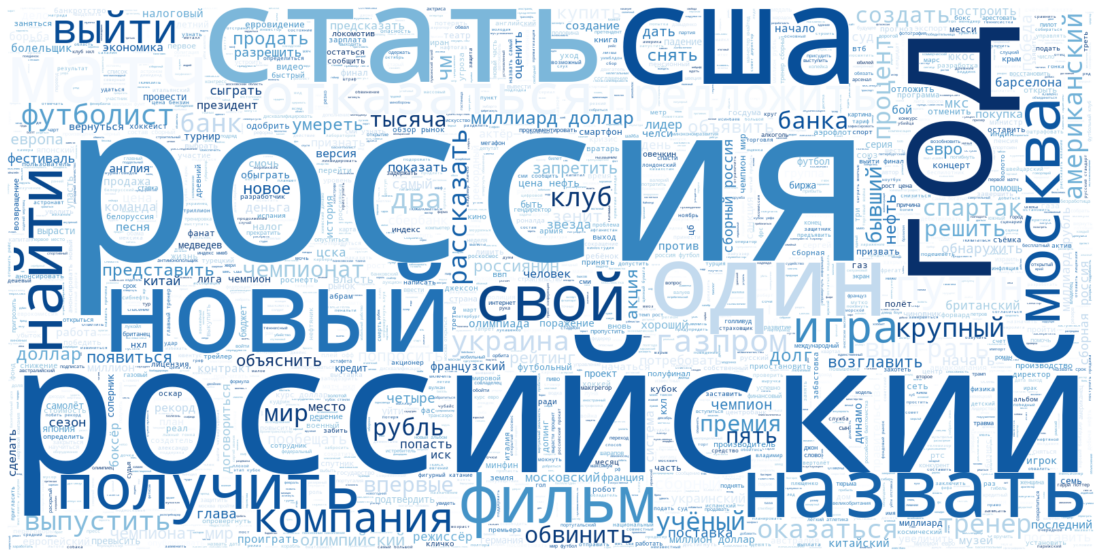

In [11]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Blues").generate(
        " ".join(data[data["is_fake"] == 0]["title_normalized"]
    )
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

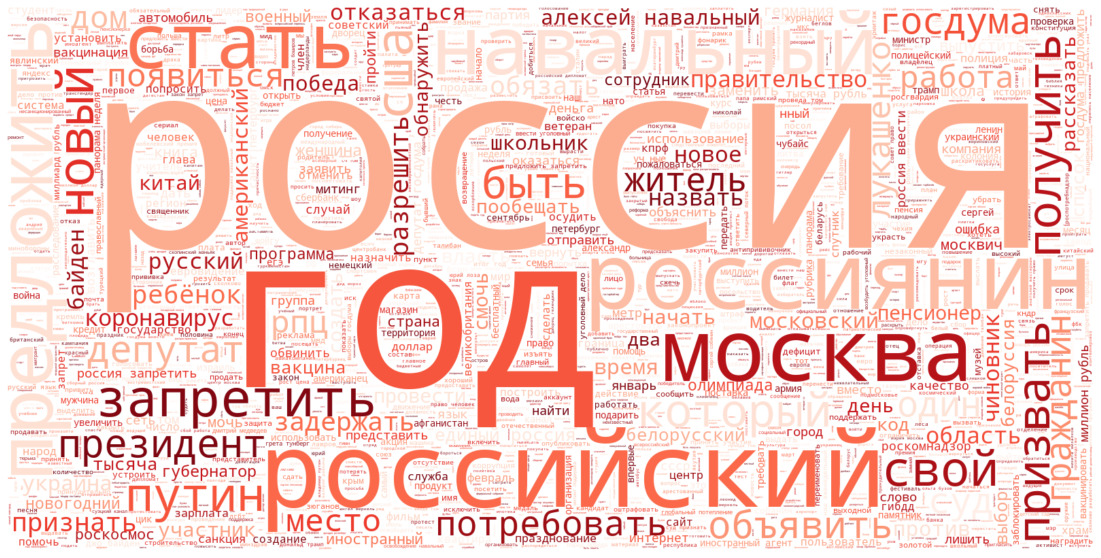

In [12]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Reds").generate(
        " ".join(data[data["is_fake"] == 1]["title_normalized"]
    )
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

### Посмотрим на распределение количества символов / слов в заголовках новостей.  
(Эти plotly диаграммы интерактивные, можно включать/выключать классы)

In [13]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Real', x=data[data["is_fake"] == 0]["title"].str.len()))
fig.add_trace(go.Histogram(name='Fake', x=data[data["is_fake"] == 1]["title"].str.len()))
fig.update_layout(title="Number of characters in the news titles")
fig

In [14]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Real', x=data[data["is_fake"] == 0]["title"].str.split().map(lambda x: len(x))))
fig.add_trace(go.Histogram(name='Fake', x=data[data["is_fake"] == 1]["title"].str.split().map(lambda x: len(x))))
fig.update_layout(title="Number of tokens in the news titles")
fig

## Посмотрим какие слова встречаются в датасете чаще всего. 
### Сначала во всём, а потом в настоящих и выдуманных по отдельности.

In [15]:
all_text = " ".join(data['title_normalized'])

In [16]:
words_counted = Counter(all_text.split())

In [17]:
data_counted = pd.DataFrame.from_dict(words_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()
data_counted.head(2)

index  counter
0      россия      536
1  российский      287

In [18]:
fig = px.bar(data_counted[:50], x='index', y='counter', title='The most common tokens in the dataset', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

In [19]:
all_real_text = " ".join(data[data["is_fake"] == 0]['title_normalized'])
all_fake_text = " ".join(data[data["is_fake"] == 1]['title_normalized'])

real_counted = Counter(all_real_text.split())
fake_counted = Counter(all_fake_text.split())

real_data_counted = pd.DataFrame.from_dict(real_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()
fake_data_counted = pd.DataFrame.from_dict(fake_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()

In [20]:
fig = px.bar(real_data_counted[:50], x='index', y='counter', title='The most common tokens in real news', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

In [21]:
fig = px.bar(fake_data_counted[:50], x='index', y='counter', title='The most common tokens in fake news', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

#### Можно добавить костыль в виде токена "Навальный" при наличии которого новость сразу попадает в выдуманную)

### Посмотрим на слова, котроые не входят в выдуманные новости и наоборот

In [22]:
real_fake = [word for word in real_data_counted['index'].to_list() if word not in fake_data_counted['index'].to_list()]
fake_real = [word for word in fake_data_counted['index'].to_list() if word not in real_data_counted['index'].to_list()]

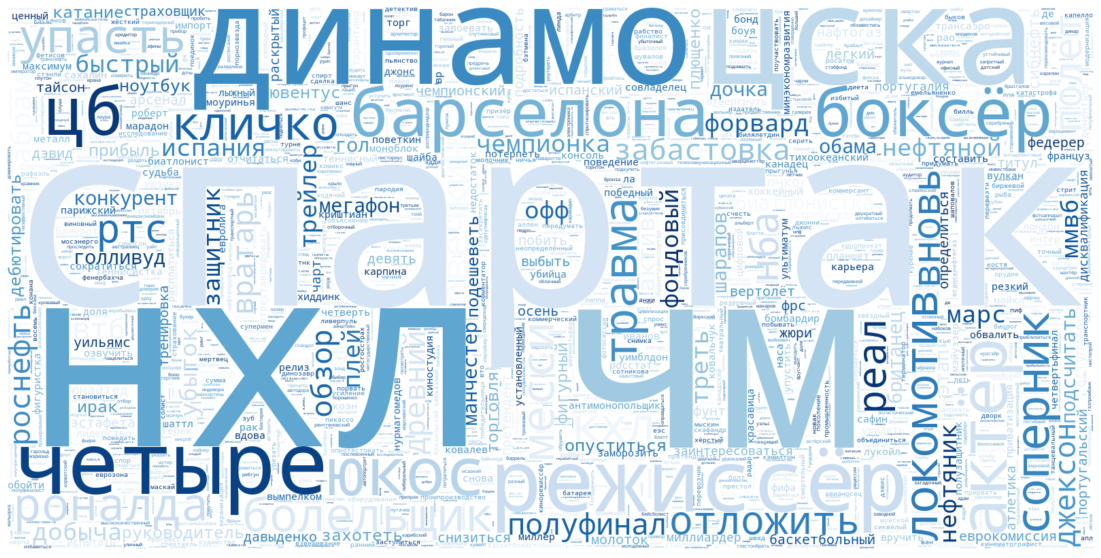

In [23]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Blues").generate(
        " ".join(real_fake)
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

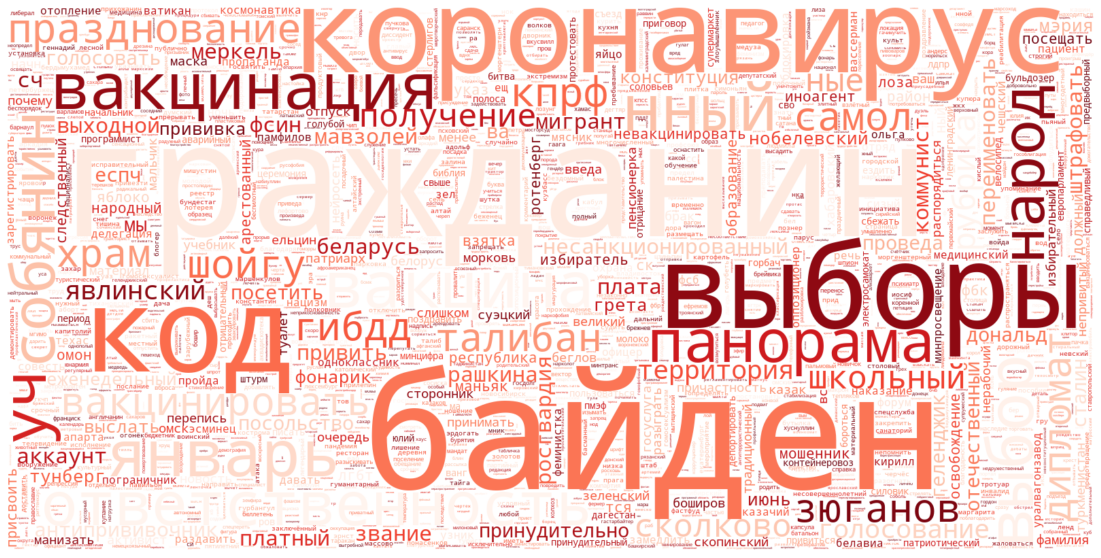

In [24]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Reds").generate(
        " ".join(fake_real)
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

# Modeling

In [25]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.3, random_state=118)

In [26]:
data_train.shape, data_test.shape

((4030, 3), (1728, 3))

### Данных мало, тем более у нас только заголовки новостей, без текста.   
Сначала хотелось спарситью всю панораму, добавить столько же из `natasha/corus` и отфильтровать то, что уже есть в датасете, но в чатике написали, что так нельзя.  
Я пробовал добавить больше данных с помощью аугментации - случайно удалял некоторые слова, случайно менял положение слов, удвоил датасет с помощью обратного перевода, но существенного прироста точности это не дало, поэтому оставил исходный и решил работать с ним.






In [27]:
results = {}

## BoW and TF-IDf 
Построим простые классификаторы из `sklearn`

In [28]:
texts_train = data_train["title_normalized"].values.tolist()
texts_test = data_test["title_normalized"].values.tolist()

y_train = data_train["is_fake"].values.tolist()
y_test = data_test["is_fake"].values.tolist()

In [29]:
from sklearn import metrics
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import (
    LinearSVC, 
    SVC
)

In [30]:
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf = TfidfVectorizer(min_df=1)

count_train = count_vect.fit_transform(texts_train)
count_test = count_vect.transform(texts_test)

tfidf_train = tfidf.fit_transform(texts_train)
tfidf_test = tfidf.transform(texts_test)

In [31]:
count_train.shape, count_test.shape, tfidf_train.shape, tfidf_test.shape

((4030, 29689), (1728, 29689), (4030, 8446), (1728, 8446))

In [32]:
mnb_count_clf = MultinomialNB(alpha=0.9)
lr_count_clf = LogisticRegression(C=12.0)
mnb_tfidf_clf = MultinomialNB(alpha=0.9)
linear_svc_tfidf_clf = LinearSVC()
sgd_tfidf_clf = SGDClassifier()
svc_tfidf_clf = SVC(kernel="linear")

In [33]:
clfs = [
        (mnb_count_clf, "multinomial nb count"),
        (mnb_tfidf_clf, "multinomial nb tfidf"),
        (lr_count_clf, "logreg count"),
        (linear_svc_tfidf_clf, "svc"),
        (sgd_tfidf_clf, "sgd"),
        (svc_tfidf_clf, "svc_tfidf")
]

In [34]:
def fit_predict(clfs):
    """Fit/predit for all sklearn classifiers"""
    for model, name in clfs:
        model_name = type(model).__name__
        if "count" in name:
            model.fit(count_train, y_train)
            pred = model.predict(count_test)
            results[f"{model_name}CountVectorizer"] = classification_report(
                y_test, pred, output_dict=True
            )
            score = f1_score(y_test, pred)
            print(f"f1 score for {model_name} is: {score}")
        else:
            model.fit(tfidf_train, y_train)
            pred = model.predict(tfidf_test)
            results[f"{model_name}TfIdfVectorizer"] = classification_report(
                y_test, pred, output_dict=True
            ) 
            score = f1_score(y_test, pred)
            print(f"f1 score for {model_name} is: {score}")

In [35]:
fit_predict(clfs)

f1 score for MultinomialNB is: 0.8624143384290985
f1 score for MultinomialNB is: 0.8471096704484063
f1 score for LogisticRegression is: 0.8248655110579796
f1 score for LinearSVC is: 0.8381374722838137
f1 score for SGDClassifier is: 0.8382109331860851
f1 score for SVC is: 0.8404196576477085


## ROC-curve

In [36]:
fig = go.Figure()
for model, name in [
    (mnb_count_clf, "multinomial nb count"),
    (mnb_tfidf_clf, "multinomial nb tfidf"),
    (lr_count_clf, "logreg count"),
    (svc_tfidf_clf, "svc"),
    (sgd_tfidf_clf, "sgd")
]:
    if "count" in name:
        pred = model.predict_proba(count_test)[:, 1]
    elif "multinomial" in name:
        pred = model.predict_proba(tfidf_test)[:, 1]
    else:
        pred = model.decision_function(tfidf_test)
    auc_score = roc_auc_score(y_test, pred)
    name = f"{name} (AUC={auc_score:.2f})"
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred, pos_label=1)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    title="ROC-curve for all models",
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1000, height=700
)
fig.show()

### Combined report

In [37]:
f1_scores_by_model_class_1 = [(results[model]["1"]["f1-score"], model) for model in results]

f1_scores = pd.DataFrame(f1_scores_by_model_class_1, columns=['f1_score', 'model']).sort_values(['f1_score'], ascending=False)
f1_scores

f1_score                              model
0  0.862414       MultinomialNBCountVectorizer
1  0.847110       MultinomialNBTfIdfVectorizer
5  0.840420                 SVCTfIdfVectorizer
4  0.838211       SGDClassifierTfIdfVectorizer
3  0.838137           LinearSVCTfIdfVectorizer
2  0.824866  LogisticRegressionCountVectorizer

In [38]:
fig = px.bar(f1_scores, x='model', y='f1_score', title='Combined report for all models', labels={'model': 'Model name', 'f1_score': 'f1 score'}, color='model')
fig.show()